**Step 1: Import Libraries**

In [3]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import joblib
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import IncrementalPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.utils import shuffle
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, log_loss

**Step 2: Loading and Preprocessing MovieLens Ratings Data**

In [4]:
# loading the ratings and movie metadata csv files
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies_metadata.csv', low_memory=False)

ratings = ratings[(ratings['rating'] >= 0.5) & (ratings['rating'] <= 5.0)]
ratings = ratings.drop_duplicates(subset=['userId', 'movieId'])

# sampling the data to 0.5 percent for faster execution
ratings = ratings.sample(frac=0.005, random_state=42).reset_index(drop=True)

print("after sampling ratings rows =", len(ratings))

# converting movie id to numeric because metadata has mixed types
movies['id'] = pd.to_numeric(movies['id'], errors='coerce')

# selecting minimum useful columns from movie metadata
movies_small = movies[['id', 'title', 'genres']].rename(columns={'id': 'movieId'})

# merging ratings with movie metadata
df = ratings.merge(movies_small, on='movieId', how='left')
print("merged data rows =", len(df))

after sampling ratings rows = 130121
merged data rows = 130124


**Step 3: Feature Engineering**

In [5]:
# creating rating categories for classification
def classify_rating(r):
    if r <= 2.5:
        return 'Not Recommended'
    elif r <= 4.0:
        return 'Recommended'
    else:
        return 'Strongly Recommended'

df['rating_cat'] = df['rating'].apply(classify_rating)

print(df['rating_cat'].value_counts())

# computing user statistics for capturing user strictness
user_stats = df.groupby('userId')['rating'].agg(['mean','std','count']).reset_index()

user_stats = user_stats.rename(columns={
    'mean': 'user_avg_rating',
    'std': 'user_std_rating',
    'count': 'user_rating_count'
})

# computing movie statistics for capturing movie popularity
movie_stats = df.groupby('movieId')['rating'].agg(['mean','std','count']).reset_index()

movie_stats = movie_stats.rename(columns={
    'mean': 'movie_avg_rating',
    'std': 'movie_std_rating',
    'count': 'movie_rating_count'
})

df = df.merge(user_stats, on='userId', how='left')
df = df.merge(movie_stats, on='movieId', how='left')

# filling missing standard deviation values with zero
df['user_std_rating'].fillna(0, inplace=True)
df['movie_std_rating'].fillna(0, inplace=True)

# creating interaction feature between user and movie averages
df['user_movie_avg_diff'] = df['user_avg_rating'] - df['movie_avg_rating']

def extract_genres(g):
    if isinstance(g, str):
        try:
            genre_list = ast.literal_eval(g)
            if isinstance(genre_list, list):
                return [d['name'] for d in genre_list if isinstance(d, dict) and 'name' in d]
        except (ValueError, SyntaxError):
            if '|' in g:
                return [x.strip() for x in g.split('|')]
            if ',' in g:
                return [x.strip() for x in g.split(',')]
    return []

df['genres_list'] = df['genres'].fillna('').apply(extract_genres)  # parse genres list

# finding most frequent genres
all_genres = [g for lst in df['genres_list'] for g in lst]
top_genres = pd.Series(all_genres).value_counts().nlargest(10).index.tolist()

# creating one hot columns for top genres
for g in top_genres:
    df[f'genre_{g}'] = df['genres_list'].apply(lambda lst: int(g in lst))

# listing final feature columns
feature_cols = [
    'user_avg_rating',
    'user_std_rating',
    'user_rating_count',
    'movie_avg_rating',
    'movie_std_rating',
    'movie_rating_count',
    'user_movie_avg_diff'
] + [f'genre_{g}' for g in top_genres]

print("final number of features =", len(feature_cols))

rating_cat
Recommended             77187
Strongly Recommended    29736
Not Recommended         23201
Name: count, dtype: int64
final number of features = 17


**Ste 4: Feature Scaling & PCA**

In [6]:
# separating features and target for model training
X = df[feature_cols].fillna(0)
y = df['rating_cat']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)
print("train size =", len(X_train))
print("test size =", len(X_test))

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# selecting number of PCA components
num_components = min(6, X_train_scaled.shape[1])
print("pca components =", num_components)

# applying incremental pca for faster dimensionality reduction
ipca = IncrementalPCA(n_components=num_components, batch_size=256)
ipca.fit(X_train_scaled)

# transforming training and testing data
X_train_pca = ipca.transform(X_train_scaled)
X_test_pca = ipca.transform(X_test_scaled)

print("pca train shape =", X_train_pca.shape)
print("pca test shape =", X_test_pca.shape)


train size = 104099
test size = 26025
pca components = 6
pca train shape = (104099, 6)
pca test shape = (26025, 6)


**Step 5: Custom Random Forest (Multi-Class) Implementation**

In [7]:
class DecisionStump:
    """A simplified multi-class decision stump."""
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.left_class = None
        self.right_class = None

    def _get_majority_class(self, y):
        """Returns the most frequent class in the label array."""
        if len(y) == 0:
            return None
        return Counter(y).most_common(1)[0][0]

    def fit(self, X, y):
        n_samples, n_features = X.shape
        best_score = -1

        for feature_i in range(n_features):
            # Use midpoints between unique feature values as thresholds
            unique_vals = np.unique(X[:, feature_i])
            if len(unique_vals) > 1:
                thresholds = (unique_vals[:-1] + unique_vals[1:]) / 2
            else:
                thresholds = unique_vals

            for threshold in thresholds:
                # Split the data
                left_idxs = X[:, feature_i] < threshold
                right_idxs = X[:, feature_i] >= threshold

                # Get majority class for each split
                left_class_c = self._get_majority_class(y[left_idxs])
                right_class_c = self._get_majority_class(y[right_idxs])
                # Calculate the "score" (number of correctly classified samples)
                score = np.sum(y[left_idxs] == left_class_c) + np.sum(y[right_idxs] == right_class_c)
                if score > best_score:
                    best_score = score
                    self.threshold = threshold
                    self.feature_index = feature_i
                    self.left_class = left_class_c
                    self.right_class = right_class_c

    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = np.empty(n_samples)
        feature = X[:, self.feature_index]
        # Handle cases where feature is below/above threshold
        left_mask = feature < self.threshold
        right_mask = feature >= self.threshold

        if self.left_class is not None:
            y_pred[left_mask] = self.left_class
        if self.right_class is not None:
            y_pred[right_mask] = self.right_class
        return y_pred.astype(int)

class CustomRandomForest(BaseEstimator, ClassifierMixin):
    _estimator_type = "classifier"
    def __init__(self, n_estimators=100, max_samples_rate=1.0):
        # Increased estimators to 100 to aim for better performance
        self.n_estimators = n_estimators
        self.max_samples_rate = max_samples_rate
        self.trees = []
        self.classes_ = None

    def fit(self, X, y):
        self.trees = []
        self.classes_ = np.unique(y)
        n_samples = len(X)
        n_samples_per_tree = int(n_samples * self.max_samples_rate)

        for _ in range(self.n_estimators):
            idxs = np.random.choice(n_samples, n_samples_per_tree, replace=True)
            stump = DecisionStump()
            stump.fit(X[idxs], y[idxs])
            self.trees.append(stump)
        return self

    def predict(self, X):
        # Gather predictions from all trees
        stump_preds = np.array([tree.predict(X) for tree in self.trees])
        stump_preds = np.swapaxes(stump_preds, 0, 1)
        y_pred = [Counter(row).most_common(1)[0][0] for row in stump_preds]
        return np.array(y_pred)

    def predict_proba(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        probabilities = np.zeros((n_samples, n_classes))

        if not self.trees:
            # If no trees are trained, return uniform probabilities or raise error
            return np.full((n_samples, n_classes), 1.0 / n_classes)

        all_tree_preds = np.array([tree.predict(X) for tree in self.trees])

        # For each sample, count votes for each class
        for i in range(n_samples):
            sample_preds = all_tree_preds[:, i]
            counts = Counter(sample_preds)
            for class_val, count in counts.items():
                # Map class_val to its index in self.classes_
                if class_val in self.classes_:
                    class_idx = np.where(self.classes_ == class_val)[0][0]
                    probabilities[i, class_idx] = count / self.n_estimators
        return probabilities

**Step 6: Custom Naive Bayes Implementation**

In [8]:
class CustomNaiveBayes(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}
        for c in self.classes:
            X_c = X[y == c]
            self.mean[c] = X_c.mean(axis=0)
            self.var[c] = X_c.var(axis=0) + 1e-9
            self.priors[c] = X_c.shape[0] / X.shape[0]
        return self # Return self for scikit-learn compatibility

    def _pdf(self, class_idx, x):
        mean = self.mean[class_idx]
        var = self.var[class_idx]
        numerator = np.exp(- (x - mean)**2 / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

    def predict(self, X):
        predictions = []
        for x in X:
            posteriors = []
            for c in self.classes:
                prior = np.log(self.priors[c])
                class_conditional = np.sum(np.log(self._pdf(c, x))) # Sum of log probabilities for each feature
                posterior = prior + class_conditional
                posteriors.append(posterior)
            predictions.append(self.classes[np.argmax(posteriors)])
        return np.array(predictions)

    def predict_proba(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        probabilities = np.zeros((n_samples, n_classes))

        for i, x in enumerate(X):
            log_posteriors = []
            for c in self.classes:
                prior = np.log(self.priors[c])
                pdf_vals = self._pdf(c, x)
                # Handle cases where pdf_vals might be zero (to prevent log(0))
                pdf_vals_safe = np.maximum(pdf_vals, 1e-100)
                class_conditional = np.sum(np.log(pdf_vals_safe))
                log_posteriors.append(prior + class_conditional)

            # Convert log posteriors to probabilities using softmax for numerical stability
            log_posteriors = np.array(log_posteriors)
            exp_log_posteriors = np.exp(log_posteriors - np.max(log_posteriors))
            sum_exp = np.sum(exp_log_posteriors)
            probabilities[i, :] = exp_log_posteriors / sum_exp
        return probabilities

**Step 7: Custom Multi-Class SVM Implementation**

In [9]:
class CustomSVM(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, lambda_param=0.0001, n_iters=8000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.class_weights = {}
        self.classifiers = {}
        self.classes = None

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.classifiers = {}
        n_samples = len(X)

        # --- 1. Calculate Class Weights ---
        class_counts = Counter(y)
        total_samples = len(y)
        for c in self.classes:
            self.class_weights[c] = total_samples / class_counts[c]

        # --- 2. Train One-vs-Rest Classifiers ---
        for c in self.classes:
            y_binary = np.where(y == c, 1, -1)
            w = np.zeros(X.shape[1])
            b = 0

            pos_weight = self.class_weights[c]

            for _ in range(self.n_iters):
                # --- NEW: SHUFFLE INDICES BEFORE EACH ITERATION (epoch) ---
                shuffled_indices = np.random.permutation(n_samples)

                # Iterate over the shuffled data
                for idx in shuffled_indices:
                    x_i = X[idx]
                    y_i = y_binary[idx]

                    margin = y_i * (np.dot(x_i, w) + b)

                    if margin >= 1:
                        w -= self.lr * (2 * self.lambda_param * w)
                    else:
                        weight_multiplier = pos_weight if y_i == 1 else 1

                        w_update = (2 * self.lambda_param * w) - (x_i * y_i * weight_multiplier)
                        w -= self.lr * w_update

                        b -= self.lr * (-y_i * weight_multiplier)

            self.classifiers[c] = (w, b)
        return self

    def predict(self, X):
        y_pred = []
        for x in X:
            scores = {c: np.dot(x, w) + b for c, (w, b) in self.classifiers.items()}
            y_pred.append(max(scores, key=scores.get))
        return np.array(y_pred)

    def decision_function(self, X):
        # For each sample, compute the raw score for each class
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        scores_array = np.zeros((n_samples, n_classes))

        # Ensure classes are sorted to maintain consistent column order for scores
        sorted_classes = sorted(self.classes)

        for i, x in enumerate(X):
            for j, c in enumerate(sorted_classes):
                if c in self.classifiers:
                    w, b = self.classifiers[c]
                    scores_array[i, j] = np.dot(x, w) + b
                else:
                    # Handle cases where a class might not have a trained classifier
                    scores_array[i, j] = 0.0
        return scores_array

**Step 8: Train and Evaluate Base Machine Learning Models (SVM, Random Forest, Naive Bayes)**

In [10]:
n_train_sample = int(len(X_train_pca) * 0.1)

X_train_sample = X_train_pca[:n_train_sample]
y_train_sample = y_train[:n_train_sample]

X_test_eval = X_test_pca
y_test_eval = y_test

X_train_np = np.array(X_train_sample)
y_train_np = np.array(y_train_sample)
X_test_np = np.array(X_test_eval)
y_test_np = np.array(y_test_eval)

# -------------------------
# Custom Random Forest
# -------------------------
crf = CustomRandomForest(n_estimators=5)
crf.fit(X_train_np, y_train_np)
y_pred_rf = crf.predict(X_test_np)

print("\n===== Custom Random Forest =====")
print("Accuracy:", round(accuracy_score(y_test_np, y_pred_rf), 3))
print("Precision:", round(precision_score(y_test_np, y_pred_rf, average='weighted'), 3))
print("Recall:", round(recall_score(y_test_np, y_pred_rf, average='weighted'), 3))
print("F1 Score:", round(f1_score(y_test_np, y_pred_rf, average='weighted'), 3))

# -------------------------
# Custom Naive Bayes
# -------------------------
cnb = CustomNaiveBayes()
cnb.fit(X_train_np, y_train_np)
y_pred_nb = cnb.predict(X_test_np)

print("\n===== Custom Naive Bayes =====")
print("Accuracy:", round(accuracy_score(y_test_np, y_pred_nb), 3))
print("Precision:", round(precision_score(y_test_np, y_pred_nb, average='weighted'), 3))
print("Recall:", round(recall_score(y_test_np, y_pred_nb, average='weighted'), 3))
print("F1 Score:", round(f1_score(y_test_np, y_pred_nb, average='weighted'), 3))

# -------------------------
# Custom SVM (One-vs-Rest)
# -------------------------
csvm = CustomSVM(learning_rate=0.001, lambda_param=0.0001, n_iters=8000)
csvm.fit(X_train_np, y_train_np)
y_pred_svm = csvm.predict(X_test_np)

print("\n===== Custom SVM =====")
print("Accuracy:", round(accuracy_score(y_test_np, y_pred_svm), 3))
print("Precision:", round(precision_score(y_test_np, y_pred_svm, average='weighted'), 3))
print("Recall:", round(recall_score(y_test_np, y_pred_svm, average='weighted'), 3))
print("F1 Score:", round(f1_score(y_test_np, y_pred_svm, average='weighted'), 3))


===== Custom Random Forest =====
Accuracy: 0.684
Precision: 0.603
Recall: 0.684
F1 Score: 0.602

===== Custom Naive Bayes =====
Accuracy: 0.749
Precision: 0.774
Recall: 0.749
F1 Score: 0.73

===== Custom SVM =====
Accuracy: 0.754
Precision: 0.755
Recall: 0.754
F1 Score: 0.747


**Step 9: Base Model Performance Metrics**

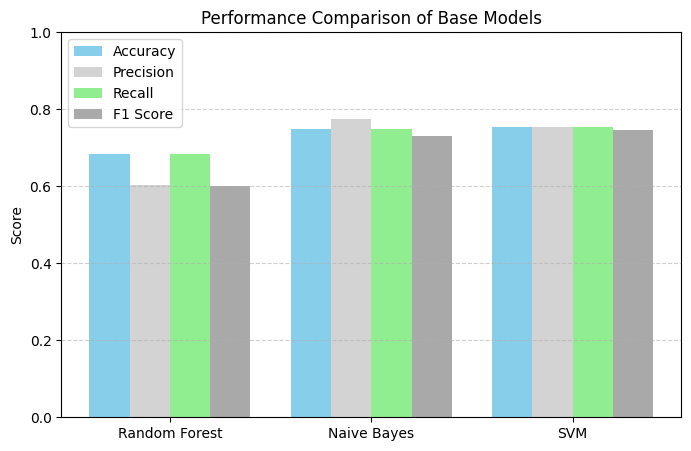

In [11]:
# Models and predictions
models = ['Random Forest', 'Naive Bayes', 'SVM']
predictions = [y_pred_rf, y_pred_nb, y_pred_svm]

# Initialize lists to store metrics
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

# Compute metrics dynamically
for y_pred in predictions:
    accuracy_list.append(round(accuracy_score(y_test_np, y_pred), 3))
    precision_list.append(round(precision_score(y_test_np, y_pred, average='weighted', zero_division=0), 3))
    recall_list.append(round(recall_score(y_test_np, y_pred, average='weighted', zero_division=0), 3))
    f1_list.append(round(f1_score(y_test_np, y_pred, average='weighted', zero_division=0), 3))

# Plot bar chart
x = np.arange(len(models))
width = 0.2

plt.figure(figsize=(8,5))
plt.bar(x - 1.5*width, accuracy_list, width, label='Accuracy', color='skyblue')
plt.bar(x - 0.5*width, precision_list, width, label='Precision', color='lightgrey')
plt.bar(x + 0.5*width, recall_list, width, label='Recall', color='lightgreen')
plt.bar(x + 1.5*width, f1_list, width, label='F1 Score', color='darkgrey')

plt.xticks(x, models)
plt.ylabel('Score')
plt.title('Performance Comparison of Base Models')
plt.ylim(0,1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

**Step 10: Implement Stacked Ensemble Model**

In [12]:
# Generate meta-features for training the meta-model
meta_train_rf = crf.predict(X_train_np)
meta_train_nb = cnb.predict(X_train_np)
meta_train_svm = csvm.predict(X_train_np)

# Stack these predictions to form X_meta_train
X_meta_train = np.column_stack((meta_train_rf, meta_train_nb, meta_train_svm))

X_meta_test = np.column_stack((y_pred_rf, y_pred_nb, y_pred_svm))

# Initialize the Logistic Regression meta-model
meta_model = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000, random_state=42)

meta_model.fit(X_meta_train, y_train_np)

# Predict the final class labels on the test meta-features
y_pred_stacked = meta_model.predict(X_meta_test)

print("--- Performance Metrics (Stacked Ensemble) ---")
print("Accuracy:", round(accuracy_score(y_test_np, y_pred_stacked), 3))
print("Precision:", round(precision_score(y_test_np, y_pred_stacked, average='weighted', zero_division=0), 3))
print("Recall:", round(recall_score(y_test_np, y_pred_stacked, average='weighted', zero_division=0), 3))
print("F1 Score:", round(f1_score(y_test_np, y_pred_stacked, average='weighted', zero_division=0), 3))
print("Log Loss:", round(log_loss(y_test_np, meta_model.predict_proba(X_meta_test)), 3))

--- Performance Metrics (Stacked Ensemble) ---
Accuracy: 0.771
Precision: 0.787
Recall: 0.771
F1 Score: 0.76
Log Loss: 0.643


**Step 11: Stacked Ensemble Performance**

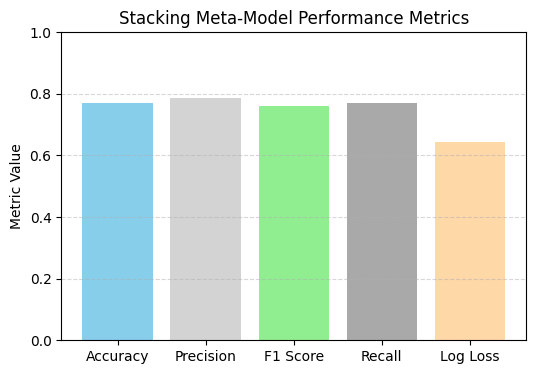

In [13]:
# Calculate metrics dynamically
accuracy = accuracy_score(y_test_np, y_pred_stacked)
precision = precision_score(y_test_np, y_pred_stacked, average='weighted', zero_division=0)
f1 = f1_score(y_test_np, y_pred_stacked, average='weighted', zero_division=0)
recall = recall_score(y_test_np, y_pred_stacked, average='weighted', zero_division=0)
logloss = log_loss(y_test_np, meta_model.predict_proba(X_meta_test))

metrics = ["Accuracy", "Precision", "F1 Score", "Recall", "Log Loss"]
values = [accuracy, precision, f1, recall, logloss]

# Bar chart for metrics
plt.figure(figsize=(6,4))
plt.bar(metrics, values, color=['skyblue', 'lightgrey', 'lightgreen', 'darkgrey',"#FFD8A8"])
plt.ylabel("Metric Value")
plt.title("Stacking Meta-Model Performance Metrics")
plt.ylim(0, 1)  # Adjust for log loss if needed
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

**Step 12: Generating Meta-Features Using Base Model Probabilities for Stacked Ensemble**

In [14]:
# Define the predict_proba method to be added to CustomSVM
def _predict_proba_for_svm(self, X):
    scores = self.decision_function(X)
    e_x = np.exp(scores - np.max(scores, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

CustomSVM.predict_proba = _predict_proba_for_svm

# Predictions of base models on the *training* data (use predict_proba)
meta_train_rf_proba = crf.predict_proba(X_train_np)
meta_train_nb_proba = cnb.predict_proba(X_train_np)
meta_train_svm_proba = csvm.predict_proba(X_train_np)

# Stack these predictions to form X_meta_train_proba
X_meta_train_proba = np.column_stack((meta_train_rf_proba, meta_train_nb_proba, meta_train_svm_proba))

# Recompute base model probabilities on test set
meta_test_rf_proba = crf.predict_proba(X_test_np)
meta_test_nb_proba = cnb.predict_proba(X_test_np)
meta_test_svm_proba = csvm.predict_proba(X_test_np)

# Stack test probabilities
X_meta_test_proba = np.column_stack((meta_test_rf_proba, meta_test_nb_proba, meta_test_svm_proba))

**Step 13: Implement Probability Calibration (Platt Scaling)**

In [15]:
# 1. Define the meta-model (Logistic Regression)
meta_model_lr = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000, random_state=42)

# 2. Wrap it with CalibratedClassifierCV
meta_model_calibrated = CalibratedClassifierCV(
    estimator=meta_model_lr,
    method='sigmoid',
    cv='prefit'
)

# Train the base Logistic Regression first
meta_model_lr.fit(X_meta_train_proba, y_train_np)

meta_model_calibrated.fit(X_meta_train_proba, y_train_np)

# 3. Predict the calibrated probabilities and class labels
y_pred_proba_calibrated = meta_model_calibrated.predict_proba(X_meta_test_proba)
y_pred_stacked_calibrated = meta_model_calibrated.predict(X_meta_test_proba)

# 4. Evaluate the new calibrated model
print("--- Performance Metrics (Probability Calibration) ---")
print("Accuracy:", round(accuracy_score(y_test_np, y_pred_stacked_calibrated), 3))
print("F1 Score:", round(f1_score(y_test_np, y_pred_stacked_calibrated, average='weighted', zero_division=0), 3))
print("Precision:", round(precision_score(y_test_np, y_pred_stacked_calibrated, average='weighted', zero_division=0), 3))
print("Recall:", round(recall_score(y_test_np, y_pred_stacked_calibrated, average='weighted', zero_division=0), 3))
print("Log Loss:", round(log_loss(y_test_np, y_pred_proba_calibrated), 3))

--- Performance Metrics (Probability Calibration) ---
Accuracy: 0.772
F1 Score: 0.762
Precision: 0.79
Recall: 0.772
Log Loss: 0.604


**Step 14: Probability Calibration Performance**

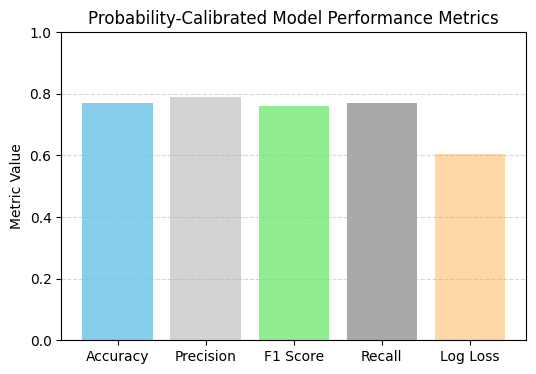

In [16]:
# Calculate metrics dynamically for calibrated model
accuracy_cal = accuracy_score(y_test_np, y_pred_stacked_calibrated)
precision_cal = precision_score(y_test_np, y_pred_stacked_calibrated, average='weighted', zero_division=0)
f1_cal = f1_score(y_test_np, y_pred_stacked_calibrated, average='weighted', zero_division=0)
recall_cal = recall_score(y_test_np, y_pred_stacked_calibrated, average='weighted', zero_division=0)
logloss_cal = log_loss(y_test_np, y_pred_proba_calibrated)

metrics = ["Accuracy", "Precision", "F1 Score", "Recall", "Log Loss"]
values = [accuracy_cal, precision_cal, f1_cal, recall_cal, logloss_cal]

# Bar chart for metrics
plt.figure(figsize=(6,4))
plt.bar(metrics, values, color=['skyblue', 'lightgrey', 'lightgreen', 'darkgrey',"#FFD8A8"])
plt.ylabel("Metric Value")
plt.title("Probability-Calibrated Model Performance Metrics")
plt.ylim(0, 1)  # Adjust for log loss if needed
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

**Step 15:  Performance Metric Comparison**

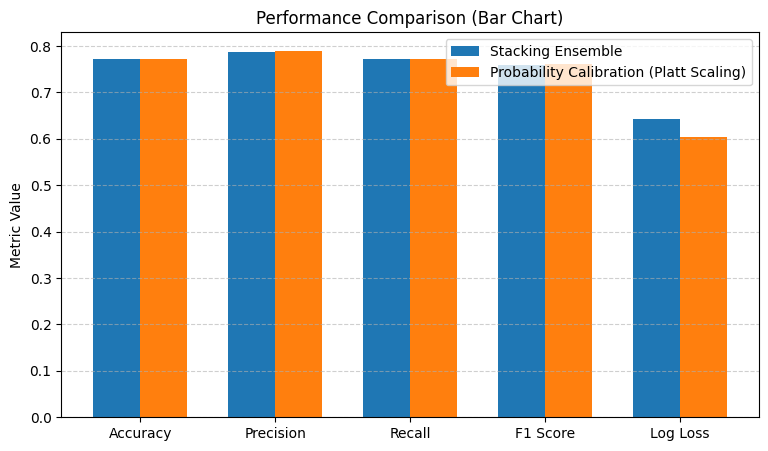

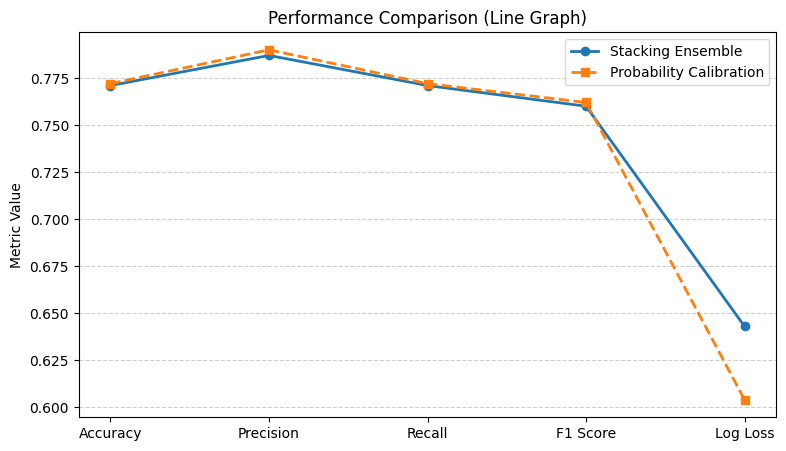

In [17]:
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "Log Loss"]

# Stacking Ensemble values
stacking_values = [
    round(accuracy_score(y_test_np, y_pred_stacked), 3),
    round(precision_score(y_test_np, y_pred_stacked, average='weighted', zero_division=0), 3),
    round(recall_score(y_test_np, y_pred_stacked, average='weighted', zero_division=0), 3),
    round(f1_score(y_test_np, y_pred_stacked, average='weighted', zero_division=0), 3),
    round(log_loss(y_test_np, meta_model.predict_proba(X_meta_test)), 3)
]

# Probability Calibration values
calibrated_values = [
    round(accuracy_score(y_test_np, y_pred_stacked_calibrated), 3),
    round(precision_score(y_test_np, y_pred_stacked_calibrated, average='weighted', zero_division=0), 3),
    round(recall_score(y_test_np, y_pred_stacked_calibrated, average='weighted',zero_division=0), 3),
    round(f1_score(y_test_np, y_pred_stacked_calibrated, average='weighted', zero_division=0), 3),
    round(log_loss(y_test_np, y_pred_proba_calibrated), 3)
]

# ============================
# Bar Chart
# ============================

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(9,5))

plt.bar(x - width/2, stacking_values, width, label="Stacking Ensemble")
plt.bar(x + width/2, calibrated_values, width, label="Probability Calibration (Platt Scaling)")

plt.title("Performance Comparison (Bar Chart)")
plt.ylabel("Metric Value")
plt.xticks(x, metrics)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# ============================================
# Reliability / Calibration Curve Comparison
# ============================================
x = np.arange(len(metrics))

plt.figure(figsize=(9,5))
plt.plot(x, stacking_values, marker='o', linestyle='-', label='Stacking Ensemble', linewidth=2)
plt.plot(x, calibrated_values, marker='s', linestyle='--', label='Probability Calibration', linewidth=2)

plt.xticks(x, metrics)
plt.ylabel("Metric Value")
plt.title("Performance Comparison (Line Graph)")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.show()